In [1]:
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from ml.common.data_utils.data_modules import HiggsDataset
from ml.common.data_utils.syn_datacreator import create_custom_multidim_dataset
from ml.common.utils.loggers import timeit, log_num_trainable_params, setup_logger
from ml.common.nn.positional_emb import MPFourier, TimeEmbedding
from ml.common.nn.unet import MPTinyUNet, TinyUNet

from ml.diffusion.EDM.losses import EDMLoss
from ml.diffusion.EDM.samplers import edm_sampler
from ml.diffusion.EDM.model import EDMPrecond, EDMPrecond2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

c:\Users\Uporabnik\Documents\IJS-F9\korlz\ml\diffusion\EDM


device(type='cpu')

Synthetic data

In [2]:
batch_size = 512

In [3]:
N_FEATURES = 18

datasetraw = create_custom_multidim_dataset(
    n_samples=10000, n_features=N_FEATURES, label_random=True, signal_frac=0.5, seed=123
)
print("dataset shape:", datasetraw.shape)  # (10000, 19)
print(datasetraw[:5])

dataset shape: (10000, 19)
[[ 3.0558233   1.471983    3.241458    5.093705    3.332919    3.066791
   3.439919    3.6857564   4.832025    3.7748506   4.160571    4.0469446
   4.4734917   3.8142502   2.1064663   5.362321    6.058531    3.8164034
   1.        ]
 [ 5.887369    4.179973    4.9646993   3.5911586   3.0370622   3.0095427
   4.0276203   4.991453    0.9456129   3.1500087   4.4882736   3.7241876
   5.7033052   2.786975    3.251972    5.1945343   4.4129176   3.149399
   1.        ]
 [-3.4078715  -2.8010852  -4.7013426  -3.0958135  -0.87410283 -1.6545234
  -5.7728295  -6.286314   -5.268909   -4.496663   -2.957793   -5.6624928
  -5.583948   -2.5322282  -4.754464   -2.603313   -3.687215   -3.498828
   0.        ]
 [ 5.4567375   2.5136514   3.9235358   3.7751567   3.6918237   2.0480313
   3.9359646   3.6579306   2.9926884   6.7949753   4.0444603   3.9171784
   6.6641273   2.3989756   2.3734653   6.676952    4.8739944   5.4676776
   1.        ]
 [ 5.3816986   2.7075596   3.268275    3

In [4]:
features_syn = [f"f{i}" for i in range(N_FEATURES)]

In [5]:
# X_syn, labels_syn = datasetraw[:, :-1], datasetraw[:, -1][:, None]
train_data_syn, val_data_syn = train_test_split(datasetraw, train_size=0.8)

print(train_data_syn.shape, val_data_syn.shape)
train_dataset_syn = HiggsDataset(train_data_syn)
val_dataset_syn = HiggsDataset(val_data_syn)

batches_train = DataLoader(
    train_dataset_syn, num_workers=0, batch_size=batch_size, shuffle=True
)
batches_val = DataLoader(
    train_dataset_syn, num_workers=0, batch_size=batch_size, shuffle=True
)

X_syn, labels_syn = next(iter(batches_train))

sigma_data = X_syn.std().numpy()

print(X_syn.shape)
# fig, ax = plt.subplots(N_FEATURES, 1)
# for idx, feature in enumerate(features_syn[:N_FEATURES]):
#     sns.histplot(X_syn[:, idx][:, None], bins=30, ax=ax[idx])
# plt.show()

(8000, 19) (2000, 19)
torch.Size([512, 18])


In [6]:
IMG_SHAPE = [2, 3, 3]
reshaped_x0 = X_syn.view(-1, *IMG_SHAPE)

loss_fn = EDMLoss(
            P_mean=-1.2,
            P_std=1.2,
            sigma_data=sigma_data
        )

model = EDMPrecond(
            MPTinyUNet(2, 32, 32, [1, 2], [False, False]), 
            sigma_data=sigma_data,
            img_shape= tuple(IMG_SHAPE)
        )

model_inner = MPTinyUNet(2, 32, 32, [1, 2], [False, False])

reshaped_x0.shape

torch.Size([512, 2, 3, 3])

In [7]:
rnd_normal = torch.randn([reshaped_x0.shape[0], 1, 1, 1])

rnd_normal.shape

torch.Size([512, 1, 1, 1])

In [8]:
Pmean = -0.4
Pstd = 1

sigma = (rnd_normal * Pstd + Pmean).exp()
sigma.shape

torch.Size([512, 1, 1, 1])

In [9]:
n = torch.randn_like(reshaped_x0) * sigma
n.shape

torch.Size([512, 2, 3, 3])

In [10]:
sigma = sigma.to(torch.float32).reshape(-1, 1, 1, 1)

c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
c_noise = sigma.log() / 4

torch.isnan(c_noise).any()

tensor(False)

In [11]:
# c_noise = c_noise.view(-1)

# plt.subplot(211)
# hist, bins, _ = plt.hist(sigma.squeeze(), bins=50)

# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# plt.subplot(212)
# plt.hist(sigma.squeeze(), bins=logbins)
# plt.xscale('log')
# plt.show()

In [12]:
D_yn = model(reshaped_x0 + n, sigma)
torch.isnan(D_yn).any()

tensor(False)

In [13]:
t_emb = TimeEmbedding(32)
t_emb.forward(sigma.squeeze())

tensor([[ 0.8251,  0.5014,  0.2804,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9292, -0.6014, -0.3421,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9734, -0.8278, -0.5036,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9602, -0.8432, -0.5167,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.5799,  0.3285,  0.1802,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.7576,  0.4486,  0.2491,  ...,  1.0000,  1.0000,  1.0000]])

In [14]:
t_embF = MPFourier(32, bandwidth=2)
t_embF.forward(sigma.squeeze()).shape

torch.Size([512, 32])

In [15]:
loss_fn(model, reshaped_x0).mean()

tensor(1.0407, grad_fn=<MeanBackward0>)

In [16]:
from collections import defaultdict

In [17]:
def calculate_magnitude(tensor):
    """Calculates per-feature L2 norm as described in EDM Appendix A.6."""
    # Ensure tensor is float32 for stable calculations
    tensor = tensor.to(torch.float32)
    
    # Reshape so that the first dimension is the one we aggregate over (N features)
    # and the second is everything else (M dimensions).
    # For a weight tensor (Out, In, K, K), this is (Out, In*K*K).
    # For an activation (B, C, H, W), this is (C, B*H*W).
    if tensor.ndim == 4: # Conv Weight or Activation
        # For activations, the paper says to reshape to N x M where N is features.
        # So we treat channels (dim 1) as N.
        tensor = tensor.permute(1, 0, 2, 3) # (C, B, H, W)
    
    # N = number of features/neurons, M = dimensionality of each feature
    N = tensor.shape[0]
    reshaped_tensor = tensor.reshape(N, -1)
    M = reshaped_tensor.shape[1]
    
    if M == 0:
        return torch.tensor([], device=tensor.device)

    # Per-feature L2 norm: sqrt(sum of squares for each feature)
    l2_norms = torch.linalg.vector_norm(reshaped_tensor, ord=2, dim=1)
    
    # Scale according to Eq. 3
    magnitudes = l2_norms / np.sqrt(M)
    return magnitudes

def get_layer_buckets(model):
    """Groups layers of the MPTinyUNet into named buckets for analysis."""
    buckets = defaultdict(list)
    for name, module in model.named_modules():
        buckets[name].append(module)
    return buckets

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MPTinyUNet(in_channels=2, base_channels=32, channel_mults=[1,2,2], use_attention_at_level=[False, False, True]).to(device)
model.eval() 

# --- Define sigma range for analysis ---
# Test across a range of noise levels, from small to large
sigmas = torch.logspace(np.log10(0.01), np.log10(100), steps=50, device=device)
log_sigmas = torch.log(sigmas)

# --- Prepare for data collection ---
layer_buckets = get_layer_buckets(model)
bucket_names = list(layer_buckets.keys())

# These dictionaries will store the aggregated results for plotting
# Format: { 'bucket_name': [mean_mag_sigma1, mean_mag_sigma2, ...], ... }
activation_results_mean = defaultdict(list)
weight_results_mean = defaultdict(list)

# --- Main Analysis Loop ---
for sigma in sigmas:
    print(f"Analyzing for sigma = {sigma.item():.2f}")

    # Create dummy input data
    dummy_x = torch.randn(40, 2, 3, 3, device=device)
    sigma_batch = sigma.expand(dummy_x.shape[0])

    # --- 1. Activation Analysis (using hooks) ---
    activations = {}
    def get_activation_hook(name):
        def hook(model, input, output):
            # Store detached tensor to avoid holding onto graph
            activations[name] = output.detach()
        return hook

    hook_handles = []
    for name, modules in layer_buckets.items():
        for module in modules:
            handle = module.register_forward_hook(get_activation_hook(name))
            hook_handles.append(handle)

    # Perform a forward pass to trigger hooks
    with torch.no_grad():
        model(dummy_x, sigma_batch)

    # Remove hooks
    for handle in hook_handles:
        handle.remove()
        
    # Process collected activations
    for name in bucket_names:
        if name in activations:
            mags = calculate_magnitude(activations[name])
            activation_results_mean[name].append(mags.mean().item())
        else:
            # Handle cases where a bucket might not produce an activation
            activation_results_mean[name].append(float('nan'))


    # --- 2. Weight Analysis ---
    for name, modules in layer_buckets.items():
        all_weight_mags = []
        for module in modules:
            for param in module.parameters():
                if param.requires_grad and param.ndim > 1: # Process weights, not biases
                    # NOTE: We are calculating the magnitude of the *raw* weight parameter.
                    # Your MPConv normalizes it internally during the forward pass.
                    # This shows the state of the learned tensor itself.
                    mags = calculate_magnitude(param.detach())
                    all_weight_mags.append(mags)
        
        if all_weight_mags:
            concatenated_mags = torch.cat(all_weight_mags)
            weight_results_mean[name].append(concatenated_mags.mean().item())
        else:
            weight_results_mean[name].append(float('nan'))


Analyzing for sigma = 0.01
Analyzing for sigma = 0.01
Analyzing for sigma = 0.01
Analyzing for sigma = 0.02
Analyzing for sigma = 0.02
Analyzing for sigma = 0.03
Analyzing for sigma = 0.03
Analyzing for sigma = 0.04
Analyzing for sigma = 0.04
Analyzing for sigma = 0.05
Analyzing for sigma = 0.07
Analyzing for sigma = 0.08
Analyzing for sigma = 0.10
Analyzing for sigma = 0.12
Analyzing for sigma = 0.14
Analyzing for sigma = 0.17
Analyzing for sigma = 0.20
Analyzing for sigma = 0.24
Analyzing for sigma = 0.29
Analyzing for sigma = 0.36
Analyzing for sigma = 0.43
Analyzing for sigma = 0.52
Analyzing for sigma = 0.63
Analyzing for sigma = 0.75
Analyzing for sigma = 0.91
Analyzing for sigma = 1.10
Analyzing for sigma = 1.33
Analyzing for sigma = 1.60
Analyzing for sigma = 1.93
Analyzing for sigma = 2.33
Analyzing for sigma = 2.81
Analyzing for sigma = 3.39
Analyzing for sigma = 4.09
Analyzing for sigma = 4.94
Analyzing for sigma = 5.96
Analyzing for sigma = 7.20
Analyzing for sigma = 8.69
A

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_6848\1835305492.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to make space for legends


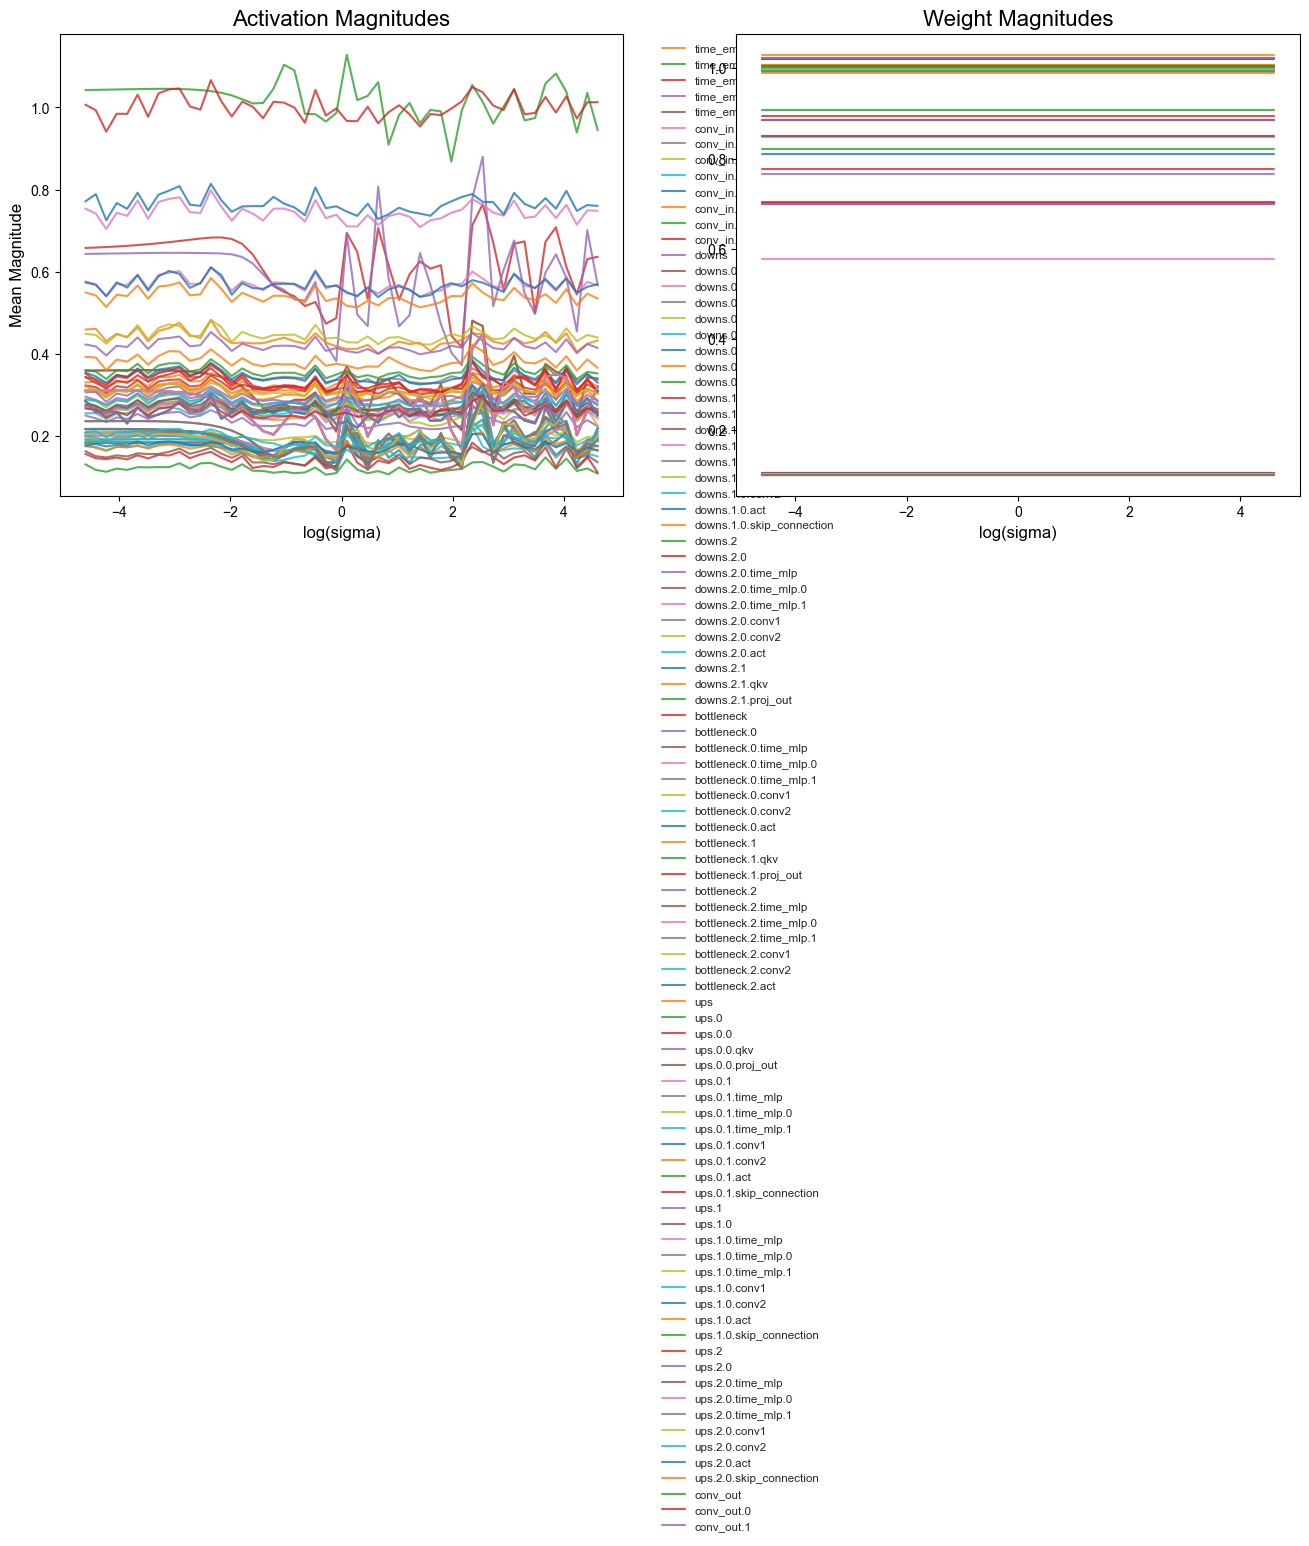

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Plot Activations ---
ax = axes[0]
for name, means in activation_results_mean.items():
    ax.plot(log_sigmas.cpu().numpy(), means, label=name, alpha=0.8)
ax.set_title("Activation Magnitudes", fontsize=16)
ax.set_xlabel("log(sigma)", fontsize=12)
ax.set_ylabel("Mean Magnitude", fontsize=12)
ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Plot Weights ---
ax = axes[1]
for name, means in weight_results_mean.items():
    ax.plot(log_sigmas.cpu().numpy(), means, label=name, alpha=0.8)
ax.set_title("Weight Magnitudes", fontsize=16)
ax.set_xlabel("log(sigma)", fontsize=12)
# ax.set_ylabel("Mean Magnitude", fontsize=12) # Y-label is shared
# ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to make space for legends
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from ml.common.nn.unet import MPConv

In [21]:
def initialize_model(model, init_type='kaiming_normal'):
    """
    Initializes model parameters based on the specified type.
    'kaiming_normal' is generally recommended for networks with ReLU-like activations.
    """
    print(f"Initializing model with '{init_type}' method...")
    
    for m in model.modules():
        # We target layers that have a 'weight' parameter.
        # This includes our custom MPConv and standard nn.Linear.
        if isinstance(m, (MPConv, nn.Linear)):
            if init_type == 'zeros':
                nn.init.zeros_(m.weight)
            elif init_type == 'normal':
                nn.init.normal_(m.weight, mean=0.0, std=1e-3)
            # elif init_type == 'normal':
            #     nn.init.normal_(m.weight, mean=0.0, std= 0.001)
            elif init_type == 'kaiming_normal':
                # Kaiming init is designed for layers followed by a ReLU activation.
                # SiLU is similar enough that this is a very strong choice.
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
            else:
                raise ValueError(f"Unknown initialization type: {init_type}")

            # Initialize biases to zero, if they exist
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.zeros_(m.bias)

In [22]:
# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 3
BATCH_SIZE = 512
LR = 5e-4

# Diffusion noise schedule parameters
P_mean = -1.2
P_std = 1.2

# --- Set up Models, Optimizers, and Loss Tracking ---
init_methods = ['Zeros', 'Normal']
models = {}
optimizers = {}
losses = {name: [] for name in init_methods}

for name in init_methods:
    model_inner = MPTinyUNet(in_channels=2, base_channels=32, channel_mults=[1,2,4], use_attention_at_level=[False, False, True]).to(device)
    model = EDMPrecond(
            model_inner, 
            sigma_data=sigma_data,
            img_shape= tuple(IMG_SHAPE)
        )
    
    loss_fn = EDMLoss(
            P_mean=-1.2,
            P_std=1.2,
            sigma_data=sigma_data
        )
    
    # Convert name to function argument format (e.g., "Kaiming Normal" -> "kaiming_normal")
    init_arg = name.lower().replace(' ', '_')
    initialize_model(model, init_type=init_arg)
    
    models[name] = model
    optimizers[name] = torch.optim.Adam(model.parameters(), lr=LR)

# --- Training Loop ---
for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    for batch in tqdm(batches_train, desc=f"Epoch {epoch+1}"):
        x0 = batch[0].to(device)
        x0 = x0.view(-1, *IMG_SHAPE)

        
        # --- Train each model on the same batch ---
        for name, model in models.items():
            optimizer = optimizers[name]
            
            optimizer.zero_grad()
            loss = loss_fn(model, x0).mean()
            loss.backward()
            optimizer.step()
            
            losses[name].append(loss.item())

print("\nTraining complete.")

Initializing model with 'zeros' method...
Initializing model with 'normal' method...

--- Epoch 1/3 ---


Epoch 1: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it]



--- Epoch 2/3 ---


Epoch 2: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]



--- Epoch 3/3 ---


Epoch 3: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


Training complete.


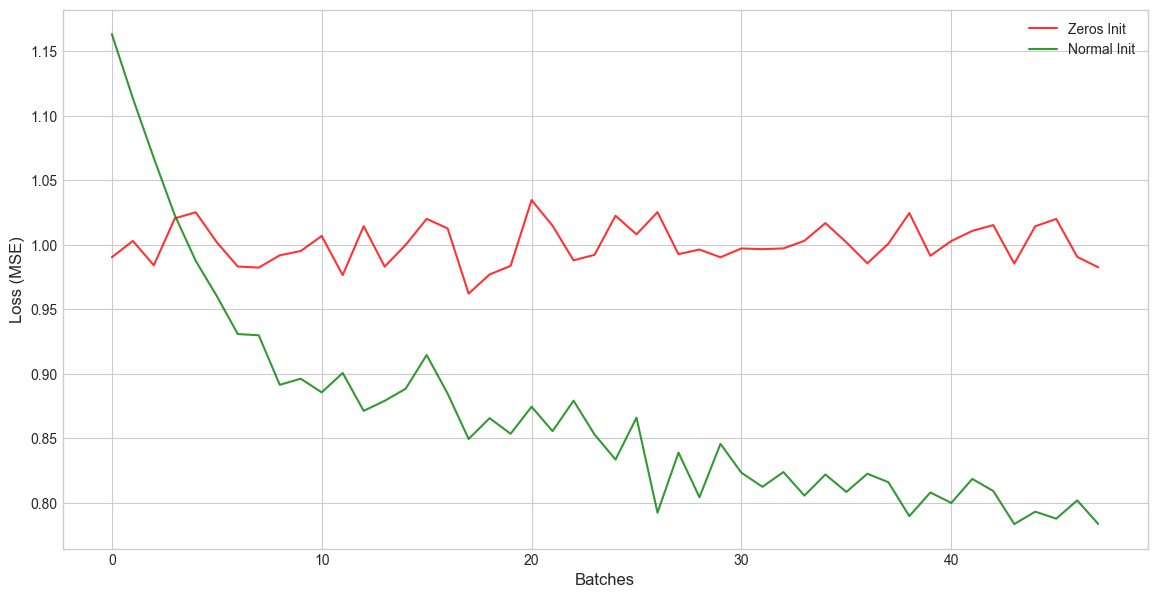

In [23]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))

colors = {
    'Zeros': 'red',
    'Normal': 'green',
    'Normal2': 'purple'
}

for name, loss_curve in losses.items():
    plt.plot(loss_curve, color=colors[name], label=f'{name} Init', alpha=0.8)

plt.xlabel('Batches', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
#plt.ylim(bottom=0, top=max(losses['Ones'][5:] or [2]) * 1.2) # Adjust y-axis to ignore initial spike
plt.show()